In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)


# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


# v_mins
n = 300
v = linspace(0.01,750.0,n)

# Times
ndays = 20
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate everything
fv_Iso = zeros(shape=(ndays,n))
fv_Iso_gf = zeros(shape=(ndays,n))
fv_Saus = zeros(shape=(ndays,n))
fv_Saus_gf = zeros(shape=(ndays,n))
fv_sub = zeros(shape=(ndays,n))
fv_sub_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    fv_Iso[i,:] = SpeedDist_Triaxial(v,days[i],sig_iso)
    fv_Iso_gf[i,:] = SpeedDist_Triaxial(v,days[i],sig_iso,GravFocus=True)
    
    fv_Saus[i,:] = SpeedDist_Triaxial(v,days[i],sig_beta)
    fv_Saus_gf[i,:] = SpeedDist_Triaxial(v,days[i],sig_beta,GravFocus=True)

    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        fv_sub[i,:] += weights[isub]*SpeedDist_Triaxial(v,days[i],sig_s,v_shift=v_s)
        fv_sub_gf[i,:] += weights[isub]*SpeedDist_Triaxial(v,days[i],sig_s,v_shift=v_s,GravFocus=True)
    
    
    print('day = ',i,'of',ndays,sum(fv_sub[i,:]),sum(fv_sub_gf[i,:]))

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))


day =  0 of 20 0.39867517996033125 0.4002228903214712
day =  1 of 20 0.3986755929261804 0.4013718972782064
day =  2 of 20 0.3986762015551475 0.40398624954310214
day =  3 of 20 0.3986771696990892 0.40543937849167383
day =  4 of 20 0.39867824310941163 0.40587163348332667
day =  5 of 20 0.39867902053864923 0.4023334166417043
day =  6 of 20 0.3986795273303311 0.40002042295340867
day =  7 of 20 0.3986797931093985 0.39908995321742946
day =  8 of 20 0.3986798080991134 0.40027251429344335
day =  9 of 20 0.3986795893156104 0.399657636008918
day =  10 of 20 0.398679179360582 0.39965161189782916
day =  11 of 20 0.39867862251752584 0.3989986819110488
day =  12 of 20 0.39867794627001873 0.3983696886056257
day =  13 of 20 0.3986771589446101 0.39825876779473307
day =  14 of 20 0.39867623494651483 0.3983513597368574
day =  15 of 20 0.39867541517508637 0.39841725662346117
day =  16 of 20 0.39867492064701004 0.3986963001601052
day =  17 of 20 0.3986746639418619 0.39938544030753076
day =  18 of 20 0.3986

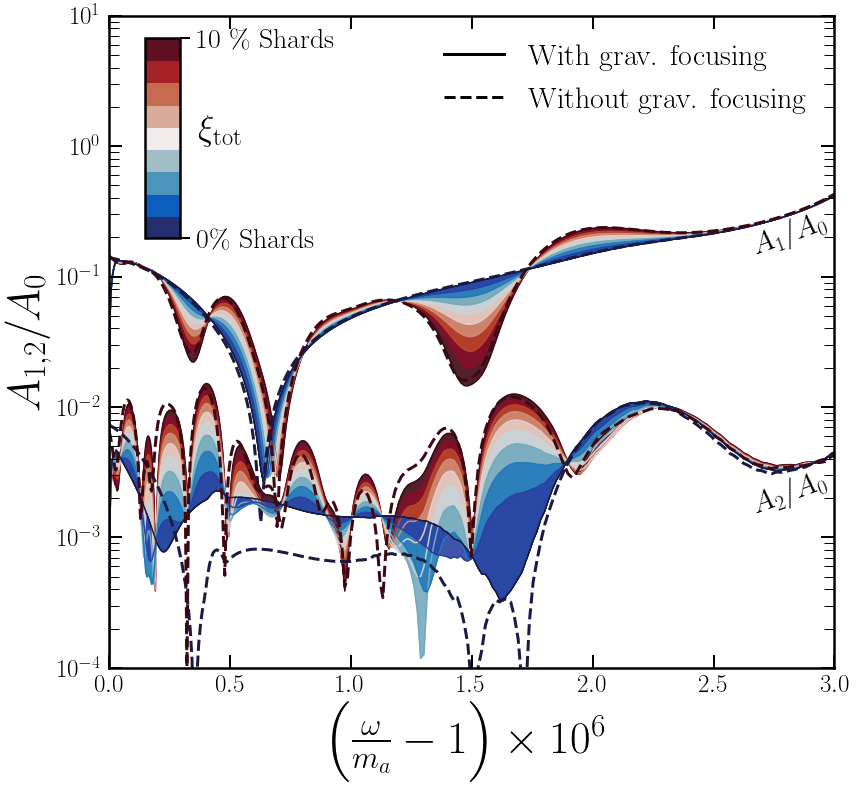

In [33]:
from PlotFuncs import *

from numpy.fft import fft

import cmocean

nt = size(days)
zorder =0

# Get all fourier components
def FourierComponents(gmin,nc):
    nv = shape(gmin)[1]
    a0 = zeros(shape=nv)
    b = zeros(shape=(nc,nv))
    a = zeros(shape=(nc,nv))
    for i in range(0,nv):
        y = gmin[:,i]
        yfft = fft(y)/(1.0*nt)
        yfft = yfft[0:(nc+1)]
        a0[i] = real(yfft[0])
        a[:,i] = 2*real(yfft[1:])
        b[:,i] = -2*imag(yfft[1:])
    return a0,a,b
nc = 5



n_xi = 10
xi_max = 0.1
xi_vals = linspace(0.0,xi_max,n_xi)

xlab = r"$\left(\frac{\omega}{m_a} - 1\right) \times 10^6$"

fig,ax1 = MySquarePlot(xlab,r'$A_{1,2}/A_0$')

eta = 0.2
col = (cmocean.cm.balance(linspace(0,1,n_xi)))

x = 1e6*0.5*(v/(3.0e8/1000))**2.0

labs = ['With']

for ic in [0,1]:

    # With GF
    zorder=0
    A0_0,a_1,b_1 = FourierComponents(((1-eta)*fv_Iso_gf+eta*fv_Saus_gf)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    for j in range(0,n_xi):
        i = n_xi-1-j
        xi = xi_vals[i]
        A0,a,b = FourierComponents(((1-xi-eta)*fv_Iso_gf+eta*fv_Saus_gf + xi*fv_sub_gf)/v,nc)
        A1 = sqrt(a[ic,:]**2.0+b[ic,:]**2.0)

        ax1.fill_between(x,A1/A0,y2=A1_0/A0_0,color=col[i,:],alpha=0.9,zorder=zorder)
        ax1.plot(x,A1/A0,'-',color=col[i,:],zorder=zorder)

    #ax1.plot(v,A1_0/A0_0,'k-',lw=3,zorder=zorder)

    # without GF
    A0_0,a_1,b_1 = FourierComponents(((1-eta)*fv_Iso+eta*fv_Saus)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    ax1.plot(x,A1_0/A0_0,'--',color=col[0,:],lw=3,zorder=zorder)

    A0_0,a_1,b_1 = FourierComponents(((1-xi_max-eta)*fv_Iso+eta*fv_Saus + xi_max*fv_sub)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    ax1.plot(x,A1_0/A0_0,'--',color=col[-1,:],lw=3,zorder=zorder)


plt.plot([-1,-1],[-2,-1],'k-',lw=3,label='With grav. focusing')
plt.plot([-1,-1],[-2,-1],'k--',lw=3,label='Without grav. focusing')
plt.legend(loc='upper right',fontsize=30,frameon=False)


plt.yscale('log')
plt.ylim([1e-4,1e1])
ax1.set_xlim(left=0.0,right=3.0)


# # Custom colorbar
plt.sca(ax1)
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax1, width="5%", height="50%", bbox_to_anchor=[-500, 350, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmocean.cm.balance, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28)
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.22,0.73,r'$\xi_{\rm tot}$',fontsize=35,color='k')

plt.gcf().text(0.81,0.6,r'$A_1/A_0$',fontsize=30,rotation=20)
plt.gcf().text(0.81,0.3,r'$A_2/A_0$',fontsize=30,rotation=20)

plt.show()

In [17]:
x

array([5.55555556e-28, 3.52331928e-23, 1.40373698e-22, 3.15422072e-22,
       5.60378314e-22, 8.75242425e-22, 1.26001440e-21, 1.71469425e-21,
       2.23928197e-21, 2.83377755e-21, 3.49818100e-21, 4.23249232e-21,
       5.03671151e-21, 5.91083857e-21, 6.85487349e-21, 7.86881629e-21,
       8.95266695e-21, 1.01064255e-20, 1.13300919e-20, 1.26236661e-20,
       1.39871483e-20, 1.54205383e-20, 1.69238362e-20, 1.84970419e-20,
       2.01401555e-20, 2.18531770e-20, 2.36361063e-20, 2.54889435e-20,
       2.74116886e-20, 2.94043416e-20, 3.14669024e-20, 3.35993711e-20,
       3.58017476e-20, 3.80740321e-20, 4.04162243e-20, 4.28283245e-20,
       4.53103325e-20, 4.78622484e-20, 5.04840722e-20, 5.31758038e-20,
       5.59374433e-20, 5.87689907e-20, 6.16704459e-20, 6.46418090e-20,
       6.76830800e-20, 7.07942589e-20, 7.39753456e-20, 7.72263401e-20,
       8.05472426e-20, 8.39380529e-20, 8.73987711e-20, 9.09293971e-20,
       9.45299311e-20, 9.82003729e-20, 1.01940723e-19, 1.05750980e-19,
      

([<matplotlib.axis.YTick at 0x11019b9b0>,
 <a list of 12 Text yticklabel objects>)

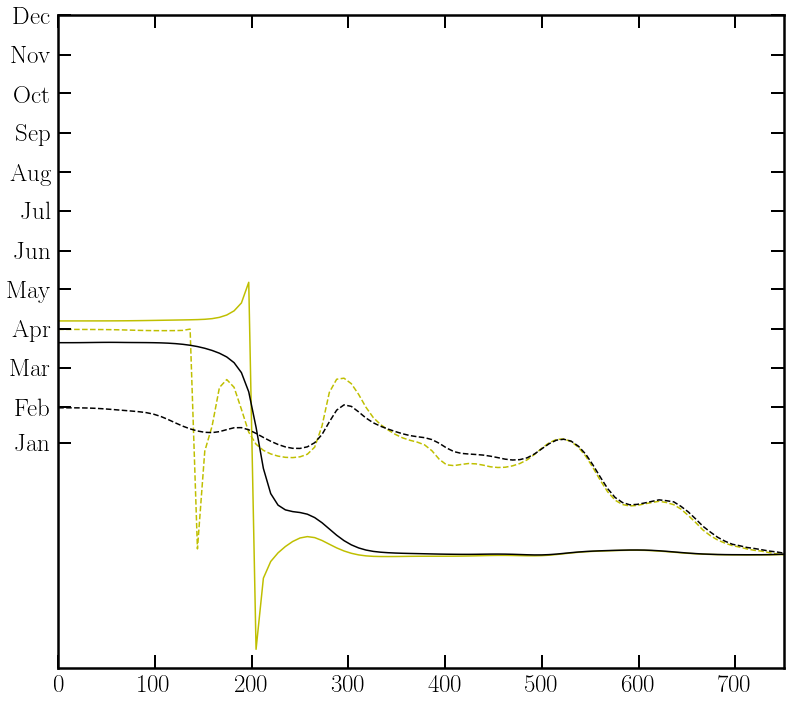

In [38]:
w = 2*pi/1.0
t0 = 0.18

def ti(a,b,n):
    ai = a[n-1,:]
    bi = b[n-1,:]
    nwt = n*w*t0
    ti = -(1.0/(n*w))*arctan2((ai*sin(nwt)-bi*cos(nwt)),(ai*cos(nwt)+bi*sin(nwt)))
    return ti 

fig,ax1 = MySquarePlot()

A0,a,b = FourierComponents(g,nc)
plt.plot(v_min,365*(-ti(a,b,2)),'y--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,365*(-ti(a,b,1)),'y-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents(g_gf,nc)
plt.plot(v_min,365*(-ti(a,b,2)),'k--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,365*(-ti(a,b,1)),'k-',lw=1.5,zorder=zorder+1)

plt.xlim([0.0,750.0])

plt.yticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=0)
#plt.ylim([130.0,365.0])

In [49]:
# Saving f(v) modulations

# v_mins
n = 200
v = linspace(0.01,750.0,n)

# Times
ndays = 365
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate everything
fv_Iso = zeros(shape=(ndays,n))
fv_Iso_gf = zeros(shape=(ndays,n))
fv_Saus = zeros(shape=(ndays,n))
fv_Saus_gf = zeros(shape=(ndays,n))
fv_sub = zeros(shape=(ndays,n))
fv_sub_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    fv_Iso[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_iso)
    fv_Iso_gf[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_iso,GravFocus=True)
    
    fv_Saus[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_beta)
    fv_Saus_gf[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_beta,GravFocus=True)

    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        fv_sub[i,:] += weights[isub]*SpeedDist_Triaxial_alt(v,days[i],sig_s,v_shift=v_s)
        fv_sub_gf[i,:] += weights[isub]*SpeedDist_Triaxial_alt(v,days[i],sig_s,v_shift=v_s,GravFocus=True)
    
    
    print('day = ',i,'of',ndays,sum(fv_sub[i,:]),sum(fv_sub_gf[i,:]))

day =  0 of 365 0.26471842380802524 0.2663527710251066
day =  1 of 365 0.2647195182951462 0.2664963028388664
day =  2 of 365 0.2647200358862808 0.2666732851401922
day =  3 of 365 0.264720980860492 0.2668009275423758
day =  4 of 365 0.264721485461476 0.26667579568610805
day =  5 of 365 0.2647221560051577 0.2668594976036829
day =  6 of 365 0.26472254414063845 0.2669946225522355
day =  7 of 365 0.2647226618008415 0.26697956787495564
day =  8 of 365 0.26472246237856567 0.2669726109532125
day =  9 of 365 0.26472297008644846 0.26709288813016685
day =  10 of 365 0.26472323461725145 0.2670460494152852
day =  11 of 365 0.26472341636422364 0.2670432876363433
day =  12 of 365 0.26472351260146976 0.26700018630351124
day =  13 of 365 0.2647232816685048 0.2670345063588675
day =  14 of 365 0.26472337108657384 0.267136650049263
day =  15 of 365 0.2647238870313251 0.26712453604719755
day =  16 of 365 0.2647241716215274 0.2671300164745739
day =  17 of 365 0.2647240786290154 0.2671520284220707
day =  18 

day =  147 of 365 0.2646569646730479 0.2664670264051745
day =  148 of 365 0.26465687855883646 0.2665311698366186
day =  149 of 365 0.2646564702200857 0.2664629356994292
day =  150 of 365 0.2646564972696908 0.26644905043628686
day =  151 of 365 0.26465683856883326 0.26636962086151106
day =  152 of 365 0.2646570357233925 0.26628548640913596
day =  153 of 365 0.2646575491650219 0.26621885875802176
day =  154 of 365 0.264657521637914 0.26625270852181804
day =  155 of 365 0.26465721337746445 0.26633807235066403
day =  156 of 365 0.26465685628308977 0.2662161445413452
day =  157 of 365 0.2646571882747364 0.2661072099176622
day =  158 of 365 0.2646577915693661 0.26606148278827746
day =  159 of 365 0.26465797453893014 0.2660307603716808
day =  160 of 365 0.2646580893024093 0.26610099506089135
day =  161 of 365 0.26465798964313475 0.2661330375149655
day =  162 of 365 0.264657874717923 0.26609001075768246
day =  163 of 365 0.26465764891305316 0.26602922606536433
day =  164 of 365 0.2646577738214

day =  292 of 365 0.2647572117844137 0.2654721137808951
day =  293 of 365 0.2647568203806101 0.26542564860398665
day =  294 of 365 0.26475579442850017 0.2654277726077558
day =  295 of 365 0.26475556850450943 0.26544818860751546
day =  296 of 365 0.26475526221519896 0.26548016337912705
day =  297 of 365 0.2647547471391991 0.2656300095573064
day =  298 of 365 0.2647543209622101 0.2656214218693712
day =  299 of 365 0.2647539783479741 0.26555353941780635
day =  300 of 365 0.2647535364480259 0.26555457340701716
day =  301 of 365 0.26475265734522735 0.26558262486035117
day =  302 of 365 0.2647517131343326 0.2656521219666703
day =  303 of 365 0.26475099561724796 0.26589066902344377
day =  304 of 365 0.264750705967717 0.2657024943102282
day =  305 of 365 0.26474954194617195 0.2656990953921834
day =  306 of 365 0.2647483299313842 0.2657336864520391
day =  307 of 365 0.26474683692954526 0.2658221284934356
day =  308 of 365 0.2647457531356166 0.26584389032599753
day =  309 of 365 0.26474457796712

(0.0, 700.0)

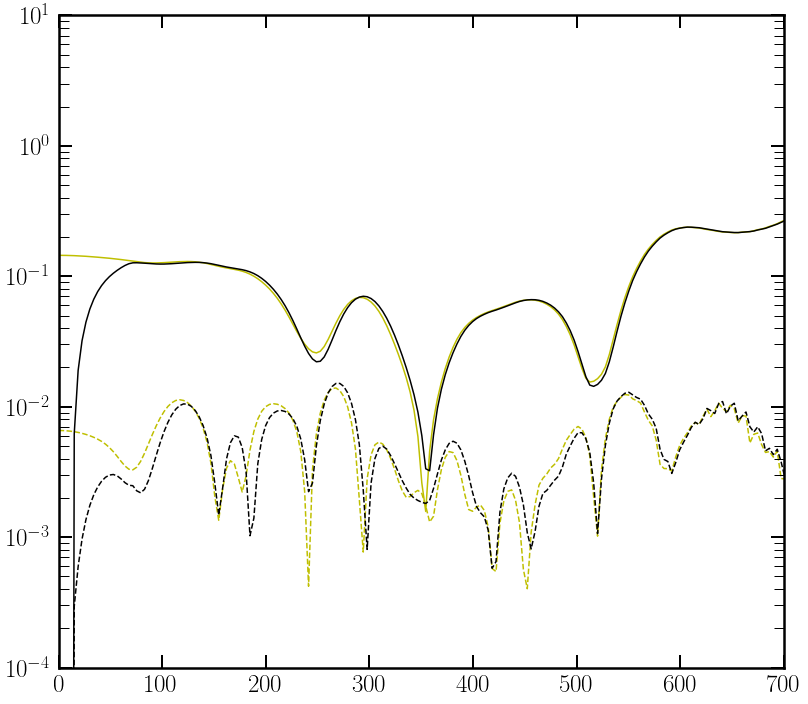

In [53]:
fig,ax1 = MySquarePlot()

xi = 0.1
eta = 0.2
fv = (1-xi-eta)*fv_Iso+eta*fv_Saus + xi*fv_sub
fv_gf = (1-xi-eta)*fv_Iso_gf+eta*fv_Saus_gf + xi*fv_sub_gf

A0,a,b = FourierComponents(fv,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v,A2/A0,'y--',lw=1.5,zorder=zorder+1)
plt.plot(v,A1/A0,'y-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents(fv_gf,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v,A2/A0,'k--',lw=1.5,zorder=zorder+1)
plt.plot(v,A1/A0,'k-',lw=1.5,zorder=zorder+1)

plt.yscale('log')
plt.ylim([1e-4,1e1])
plt.xlim([0.0,700.0])

In [56]:
12*32**2.0

12288.0

In [55]:
100*100

10000